In [39]:
%matplotlib inline


==========================
GOES-16: True Color Recipe
==========================
By: [Brian Blaylock](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/home.html)
with help from Julien Chastang (UCAR-Unidata).

Additional notebooks analyzing GOES-16 and other data can be found in [Brian's
GitHub repository](https://github.com/blaylockbk/pyBKB_v3/).

This notebook shows how to make a true color image from the GOES-16
Advanced Baseline Imager (ABI) level 2 data. We will plot the image with
matplotlib and Cartopy. The methods shown here are stitched together from the
following online resources:


- [**CIMSS True Color RGB Quick Guide**](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_CIMSSRGB_v2.pdf)
- [ABI Bands Quick Information Guides](https://www.goes-r.gov/education/ABI-bands-quick-info.html)
- [Open Commons Consortium](http://edc.occ-data.org/goes16/python/)
- [GeoNetCast Blog](https://geonetcast.wordpress.com/2017/07/25/geonetclass-manipulating-goes-16-data-with-python-part-vi/)
- [Proj documentation](https://proj4.org/operations/projections/geos.html?highlight=geostationary)

True color images are an RGB composite of the following three channels:

|        --| Wavelength   | Channel | Description   |
|----------|--------------|---------|---------------|
| **Red**  | 0.64 &#181;m |    2    | Red Visible   |
| **Green**| 0.86 &#181;m |    3    | Veggie Near-IR|
| **Blue** | 0.47 &#181;m |    1    | Blue Visible  |

For this demo, we use the **Level 2 Multichannel formated data** (ABI-L2-MCMIP)
for the CONUS domain. This file contains all sixteen channels on the ABI fixed
grid (~2 km grid spacing).

GOES-16 data is downloaded from Unidata, but you may also
download GOES-16 or 17 files from NOAA's GOES archive on [Amazon S3](https://aws.amazon.com/public-datasets/goes/).
I created a [web interface](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?source=aws&satellite=noaa-goes16&domain=C&product=ABI-L2-MCMIP)
to easily download files from the Amazon archive. For scripted or bulk
downloads, you should use `rclone` or `AWS CLI`. You may also download files
from the [Environmental Data Commons](http://edc.occ-data.org/goes16/getdata/)
and [NOAA
CLASS](https://www.avl.class.noaa.gov/saa/products/search?sub_id=0&datatype_family=GRABIPRD&submit.x=25&submit.y=9).

File names have the following format...

`OR_ABI-L2-MCMIPC-M3_G16_s20181781922189_e20181781924562_c20181781925075.nc`

`OR`     - Indicates the system is operational

`ABI`    - Instrument type

`L2`     - Level 2 Data

`MCMIP`  - Multichannel Cloud and Moisture Imagery products

`c`      - CONUS file (created every 5 minutes).

`M3`     - Scan mode

`G16`    - GOES-16

`sYYYYJJJHHMMSSZ` - Scan start: 4 digit year, 3 digit day of year (Julian day), hour, minute, second, tenth second

`eYYYYJJJHHMMSSZ` - Scan end

`cYYYYJJJHHMMSSZ` - File Creation
`.nc`    - NetCDF file extension


First, import the libraries we will use
---------------------------------------



In [40]:
from datetime import datetime

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import numpy as np
import xarray

Open the GOES-16 NetCDF File
----------------------------



In [41]:
# Open the file with xarray.
# The opened file is assigned to "C" for the CONUS domain.

FILE = ('http://ramadda-jetstream.unidata.ucar.edu/repository/opendap'
        '/4ef52e10-a7da-4405-bff4-e48f68bb6ba2/entry.das#fillmismatch')
C = xarray.open_dataset(FILE)

Date and Time Information
----------------------------
Each file represents the data collected during one scan sequence for the
domain. There are several different time stamps in this file, which are also
found in the file's name.
I'm not a fan of numpy datetime, so I convert it to a regular datetime



In [42]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : {}'.format(scan_start))
print('Scan midpoint : {}'.format(scan_mid))
print('Scan End      : {}'.format(scan_end))
print('File Created  : {}'.format(file_created))
print('Scan Duration : {:.2f} minutes'.format((scan_end-scan_start).seconds/60))

Scan Start    : 2018-10-10 14:32:20.300000
Scan midpoint : 2018-10-10 14:33:38.900000
Scan End      : 2018-10-10 14:34:57.600000
File Created  : 2018-10-10 14:35:08.800000
Scan Duration : 2.62 minutes


True Color RGB Recipe
---------------------

Color images are a Red-Green-Blue (RGB) composite of three different
channels. To make a "Natural True Color" image we assign the following
channels as our R, G, and B values:

| --                   | RED         | GREEN          | BLUE         |
|----------------------|-------------|----------------|--------------|
| **Name**             | Red Visible | Near-IR Veggie | Blue Visible |
| **Wavelength**       | 0.64 µm     | 0.86 µm        | 0.47 µm      |
| **Channel**          | 2           | 3              | 1            |
| **Units**            | Reflectance | Reflectance    | Reflectance  |
| **Range of Values**  | 0-1         | 0-1            | 0-1          |
| **Gamma Correction** | 2.2         | 2.2            | 2.2          |


Some important details to know about...

**Value Range**: The data units of channel 1, 2, and 3 are in reflectance and
have a range of values between 0 and 1. RGB values must also be between 0 and
1.

**Gamma Correction**: A gamma correction is applied to control the brightness
and make the image not look too dark.
`corrected_value = value^(1/gamma)`.
Most displays have a decoding gamma of 2.2. Read more about gamma correction
at the following links...
[source1](https://en.wikipedia.org/wiki/Gamma_correction) and
[source2](https://www.cambridgeincolour.com/tutorials/gamma-correction.htm)).

**True Green**: The GREEN "veggie" channel on GOES-16 does not measure
visible green light. Instead, it measures a near-infrared band sensitive to
chlorophyll. We could use that channel in place of green, but it would make
the green in our image appear too vibrant. Instead, we will tone-down the
green channel by interpolating the value to simulate a natural green color.

      `TrueGreen = (0.45*RED) + (0.1*GREEN) + (0.45*BLUE)`

Now we can begin putting the pieces together...



In [43]:
# Confirm that each band is the wavelength we are interested in
for band in [2, 3, 1]:
    print('{} is {:.2f} {}'.format(
        C['band_wavelength_C{:02d}'.format(band)].long_name,
        float(C['band_wavelength_C{:02d}'.format(band)][0]),
        C['band_wavelength_C{:02d}'.format(band)].units))

ABI band 2 central wavelength is 0.64 um
ABI band 3 central wavelength is 0.87 um
ABI band 1 central wavelength is 0.47 um


In [44]:
# Load the three channels into appropriate R, G, and B variables
R = C['CMI_C02'].data
G = C['CMI_C03'].data
B = C['CMI_C01'].data

In [45]:
# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

In [46]:
# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

In [47]:
# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.clip(G_true, 0, 1)  # apply limits again, just in case.

Simple Image
-----------------

Use `plt.imshow` to get a quick look at the channels and RGB composite we
created.

First, plot each channel individually. The deeper the color means the
satellite is observing more light in that channel. Clouds appear white because
they reflect lots of red, green, and blue light. Notice that the land reflects
a lot of "green" in the veggie channel because this channel is sensitive to
the chlorophyll.



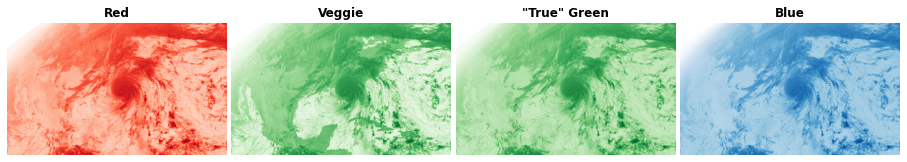

In [48]:
fig, ([ax1, ax2, ax3, ax4]) = plt.subplots(1, 4, figsize=(16, 3))

ax1.imshow(R, cmap='Reds', vmax=1, vmin=0)
ax1.set_title('Red', fontweight='bold')
ax1.axis('off')

ax2.imshow(G, cmap='Greens', vmax=1, vmin=0)
ax2.set_title('Veggie', fontweight='bold')
ax2.axis('off')

ax3.imshow(G_true, cmap='Greens', vmax=1, vmin=0)
ax3.set_title('"True" Green', fontweight='bold')
ax3.axis('off')

ax4.imshow(B, cmap='Blues', vmax=1, vmin=0)
ax4.set_title('Blue', fontweight='bold')
ax4.axis('off')

plt.subplots_adjust(wspace=.02)

In [49]:
np.dstack

<function numpy.dstack(tup)>

The addition of the three channels results in a color image. Combine the three
channels with a stacked array and display the image with `imshow`.



(-0.5, 2499.5, 1499.5, -0.5)

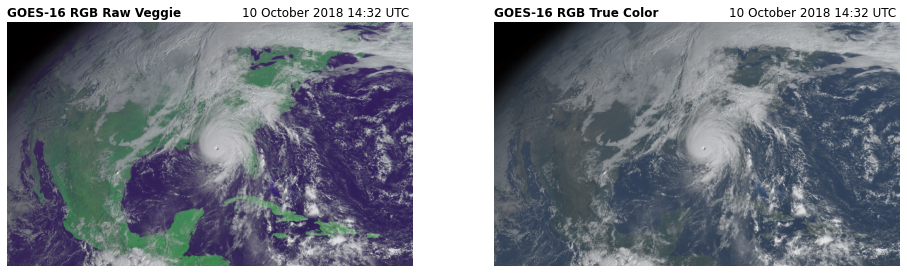

In [50]:
# The RGB array with the raw veggie band
RGB_veggie = np.dstack([R, G, B])

# The RGB array for the true color image
RGB = np.dstack([R, G_true, B])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# The RGB using the raw veggie band
ax1.imshow(RGB_veggie)
ax1.set_title('GOES-16 RGB Raw Veggie', fontweight='bold', loc='left',
              fontsize=12)
ax1.set_title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')),
              loc='right')
ax1.axis('off')

# The RGB for the true color image
ax2.imshow(RGB)
ax2.set_title('GOES-16 RGB True Color', fontweight='bold', loc='left',
              fontsize=12)
ax2.set_title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')),
              loc='right')
ax2.axis('off')

Plot with `Cartopy` Geostationary Projection
----------------------------------------------

The image above is not georeferenced. You can see the land and oceans, but we
do have enough information to draw state and country boundaries. Use the
`metpy.io` package to obtain the projection information from the file.  Then
use `Cartopy` to plot the image on a map. The GOES data and image is on a
[geostationary projection
](https://proj4.org/operations/projections/geos.html?highlight=geostationary).



In [51]:
# We'll use the `CMI_C02` variable as a 'hook' to get the CF metadata.
dat = C.metpy.parse_cf('CMI_C02')

geos = dat.metpy.cartopy_crs

# We also need the x (north/south) and y (east/west) axis sweep of the ABI data
x = dat.x
y = dat.y

The geostationary projection is the easiest way to plot the image on a
map. Essentially, we are stretching the image across a map with the same
projection and dimensions as the data.



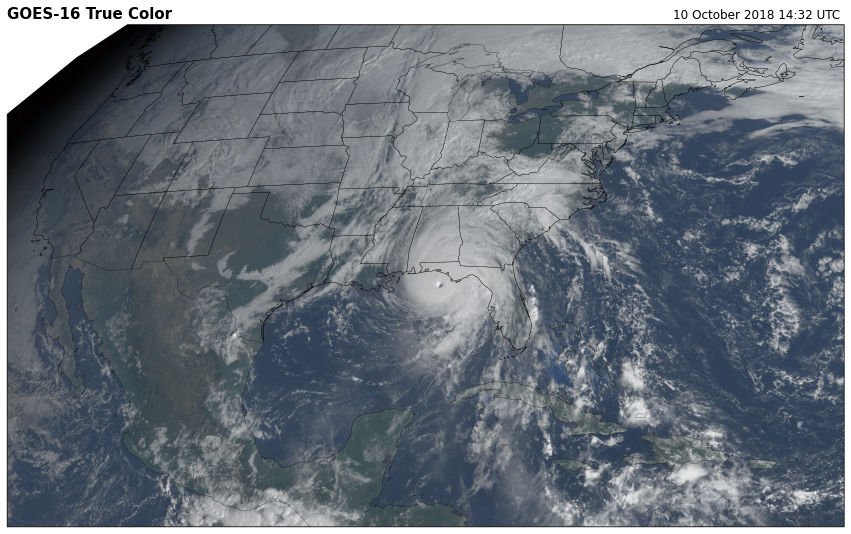

In [52]:
fig = plt.figure(figsize=(15, 12))

# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=geos)

# Add the RGB image to the figure. The data is in the same projection as the
# axis we just created.
ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()), transform=geos)

# Add Coastlines and States
ax.coastlines(resolution='50m', color='black', linewidth=0.25)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)

plt.title('GOES-16 True Color', loc='left', fontweight='bold', fontsize=15)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right')

plt.show()

Using other projections
----------------------------------------------

Changing the projections with `Cartopy` is straightforward. Here we display
the GOES-16 data on a Lambert Conformal projection.



In [ ]:
fig = plt.figure(figsize=(15, 12))

# Generate an Cartopy projection
lc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5,
                                                                        38.5))

ax = fig.add_subplot(1, 1, 1, projection=lc)
ax.set_extent([-135, -60, 10, 65], crs=ccrs.PlateCarree())

ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos,
          interpolation='none')
ax.coastlines(resolution='50m', color='black', linewidth=0.5)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)

plt.title('GOES-16 True Color', loc='left', fontweight='bold', fontsize=15)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right')

plt.show()

Plot with `Cartopy`: Plate Carrée  Cylindrical Projection
---------------------------------------------------------

It is often useful to zoom on a specific location. This image will zoom in on
Utah.



In [ ]:
fig = plt.figure(figsize=(8, 8))

pc = ccrs.PlateCarree()

ax = fig.add_subplot(1, 1, 1, projection=pc)
ax.set_extent([-114.75, -108.25, 36, 43], crs=pc)

ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos,
          interpolation='none')

ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(ccrs.cartopy.feature.STATES)

plt.title('GOES-16 True Color', loc='left', fontweight='bold', fontsize=15)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right')

plt.show()

Overlay Nighttime IR when dark
------------------------------

At nighttime, the visible wavelengths do not measure anything and is just
black. There is information, however, from other channels we can use to see
clouds at night. To view clouds in portions of the domain experiencing
nighttime, we will overlay the clean infrared (IR) channel over the true color
image.

First, open a file where the scan shows partial night area and create the true
color RGB as before.



In [ ]:
# A GOES-16 file with half day and half night

FILE = ('http://ramadda-jetstream.unidata.ucar.edu/repository/opendap'
        '/85da3304-b910-472b-aedf-a6d8c1148131/entry.das#fillmismatch')
C = xarray.open_dataset(FILE)

# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Create the RGB like we did before

# Load the three channels into appropriate R, G, and B
R = C['CMI_C02'].data
G = C['CMI_C03'].data
B = C['CMI_C01'].data

# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

# Apply the gamma correction
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.clip(G_true, 0, 1)

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

Load the Clear IR  10.3 µm channel (Band 13)
-------------------------------------------------------

When you print the contents of channel 13, notice that the unit of the clean
IR channel is *brightness temperature*, NOT reflectance. We need to normalize
the values between 0 and 1 before we can use it in our RGB image.  In this
case, we normalize the values between 90 Kelvin and 313 Kelvin.



In [ ]:
print(C['CMI_C13'])

Apply the normalization...



In [ ]:
cleanIR = C['CMI_C13'].data

# Normalize the channel between a range.
#       cleanIR = (cleanIR-minimumValue)/(maximumValue-minimumValue)
cleanIR = (cleanIR-90)/(313-90)

# Apply range limits to make sure values are between 0 and 1
cleanIR = np.clip(cleanIR, 0, 1)

# Invert colors so that cold clouds are white
cleanIR = 1 - cleanIR

# Lessen the brightness of the coldest clouds so they don't appear so bright
# when we overlay it on the true color image.
cleanIR = cleanIR/1.4

# Yes, we still need 3 channels as RGB values. This will be a grey image.
RGB_cleanIR = np.dstack([cleanIR, cleanIR, cleanIR])

Show the true color and clean IR images
---------------------------------------

We want to overlay these two images, so the clean IR fills in the night sky
on the True Color image. This way we can still see the clouds at night.



In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title('True Color', fontweight='bold')
ax1.imshow(RGB)
ax1.axis('off')

ax2.set_title('Clean IR', fontweight='bold')
ax2.imshow(RGB_cleanIR)
ax2.axis('off')

plt.show()

To fill in the dark area on the true color image, we will set each RGB channel
to equal the maximum value between the visible channels and the IR
channels. When this is done, where RGB values are black in the true color
image RGB = (0,0,0), it will be replaced with a higher value of the `cleanIR
RGB`.

Note that if the clean IR has really bright, cold clouds in the daylight, they
will replace the color values in the true color image making the clouds appear
more white. Still, it makes a nice plot and let's you see clouds when it is
night.



In [ ]:
# Maximize the RGB values between the True Color Image and Clean IR image
RGB_ColorIR = np.dstack([np.maximum(R, cleanIR), np.maximum(G_true, cleanIR),
                         np.maximum(B, cleanIR)])

In [ ]:
fig = plt.figure(figsize=(15, 12))

ax = fig.add_subplot(1, 1, 1, projection=geos)

ax.imshow(RGB_ColorIR, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos)

ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.add_feature(ccrs.cartopy.feature.STATES)

plt.title('GOES-16 True Color and Night IR', loc='left', fontweight='bold',
          fontsize=15)
plt.title('{}'.format(scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right'),
          loc='right')

plt.show()

Adjust Image Contrast
---------------------

I think the color looks a little dull. We could get complicated and make a
Rayleigh correction to the data to fix the blue light scattering, but that can
be intense. More simply, we can make the colors pop out by adjusting the image
contrast. Adjusting image contrast is easy to do in Photoshop, and also easy
to do in Python.

We are still using the RGB values from the day/night GOES-16 ABI scan.

Note: you should adjust the contrast _before_ you add in the Clean IR channel.



In [ ]:
def contrast_correction(color, contrast):
    """
    Modify the contrast of an RGB
    See:
    https://www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

    Input:
        color    - an array representing the R, G, and/or B channel
        contrast - contrast correction level
    """
    F = (259*(contrast + 255))/(255.*259-contrast)
    COLOR = F*(color-.5)+.5
    COLOR = np.clip(COLOR, 0, 1)  # Force value limits 0 through 1.
    return COLOR


# Amount of contrast
contrast_amount = 105

# Apply contrast correction
RGB_contrast = contrast_correction(RGB, contrast_amount)

# Add in clean IR to the contrast-corrected True Color image
RGB_contrast_IR = np.dstack([np.maximum(RGB_contrast[:, :, 0], cleanIR),
                             np.maximum(RGB_contrast[:, :, 1], cleanIR),
                             np.maximum(RGB_contrast[:, :, 2], cleanIR)])

In [ ]:
# Plot on map with Cartopy

fig = plt.figure(figsize=(15, 12))

ax1 = fig.add_subplot(1, 2, 1, projection=geos)
ax2 = fig.add_subplot(1, 2, 2, projection=geos)

ax1.imshow(RGB_ColorIR, origin='upper',
           extent=(x.min(), x.max(), y.min(), y.max()),
           transform=geos)
ax1.coastlines(resolution='50m', color='black', linewidth=2)
ax1.add_feature(ccrs.cartopy.feature.BORDERS)
ax1.set_title('True Color and Night IR')

ax2.imshow(RGB_contrast_IR, origin='upper',
           extent=(x.min(), x.max(), y.min(), y.max()),
           transform=geos)
ax2.coastlines(resolution='50m', color='black', linewidth=2)
ax2.add_feature(ccrs.cartopy.feature.BORDERS)
ax2.set_title('Contrast Correction = {}'.format(contrast_amount))

plt.subplots_adjust(wspace=.02)

Can we make plots for a Mesoscale scan?
---------------------------------------

Yes. Yes we can.



In [ ]:
# M1 is for the Mesoscale1 NetCDF file

FILE = ('http://ramadda-jetstream.unidata.ucar.edu/repository/opendap'
        '/5e02eafa-5cee-4d00-9f58-6e201e69b014/entry.das#fillmismatch')
M1 = xarray.open_dataset(FILE)

# Load the RGB arrays
R = M1['CMI_C02'][:].data
G = M1['CMI_C03'][:].data
B = M1['CMI_C01'][:].data

# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

# Apply the gamma correction
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.clip(G_true, 0, 1)

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

# Scan's start time, converted to datetime object
scan_start = datetime.strptime(M1.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# We'll use the `CMI_C02` variable as a 'hook' to get the CF metadata.
dat = M1.metpy.parse_cf('CMI_C02')

# Need the satellite sweep x and y values, too.
x = dat.x
y = dat.y

In [ ]:
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(1, 1, 1, projection=lc)
ax.set_extent([-125, -70, 25, 50], crs=ccrs.PlateCarree())

ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos)

ax.coastlines(resolution='50m', color='black', linewidth=0.5)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)

plt.title('GOES-16 True Color', fontweight='bold', fontsize=15, loc='left')
plt.title('Mesoscale Section 1')
plt.title('{}'.format(scan_start.strftime('%H:%M UTC %d %B %Y')), loc='right')

plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 12))

ax = fig.add_subplot(1, 1, 1, projection=geos)

ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos)

ax.coastlines(resolution='50m', color='black', linewidth=0.25)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)

plt.title('GOES-16 True Color', fontweight='bold', fontsize=15, loc='left')
plt.title('Mesoscale Section 1')
plt.title('{}'.format(scan_start.strftime('%H:%M UTC %d %B %Y')), loc='right')

plt.show()

Can we do this for a Full Disk Scan? It's possible...
-----------------------------------------------------

but data files are so large that plotting is very slow.  Feel free to
experiment.



In [ ]:
FILE = ('http://ramadda-jetstream.unidata.ucar.edu/repository/opendap'
        '/deb91f58-f997-41a3-a077-987529bf02b3/entry.das#fillmismatch')
F = xarray.open_dataset(FILE)

# Load the RGB arrays
R = F['CMI_C02'][:].data
G = F['CMI_C03'][:].data
B = F['CMI_C01'][:].data

# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

# Apply the gamma correction
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.clip(G_true, 0, 1)

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

# We'll use the `CMI_C02` variable as a 'hook' to get the CF metadata.
dat = F.metpy.parse_cf('CMI_C02')

x = dat.x
y = dat.y

Geostationary projection is easy...



In [ ]:
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(1, 1, 1, projection=geos)

ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos)

ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=1)

plt.title('GOES-16 True Color', fontweight='bold', fontsize=15, loc='left')
plt.title('Full Disk\n{}'.format(scan_start.strftime('%H:%M UTC %d %B %Y')),
          loc='right')

plt.show()